<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>


<h1 style="text-align: center;">Evaluating using Model Grade Score</h1>


**What is Model Grade Score?**: An operator to calculate the grade score of text completions using a custom prompt for grading. It is a wrapper using the same utilities from the OpenAI evals library, replacing just the completion call.

**How is it used?**: To use this operator, you can create your own custom prompt template. In this prompt template, you provide the LLM with the data that should be used to evaluate. This includes your query, context, response etc. Along with this you give it a few options, that you will use to grade the response.

#### Create an API Key

To get started, you will first need to get your API key from the [Uptrain Website](https://uptrain.ai/dashboard).

1. Login with Google
2. Click on "Create API Key"
3. Copy the API key and save it somewhere safe


#### Install the Uptrain Python Package

In [ ]:
!pip install uptrain

#### Step 1: Create an API Client

In [3]:
from uptrain import APIClient, Settings

settings = Settings(
    uptrain_access_token=YOUR_API_KEY,
    uptrain_server_url="https://demo.uptrain.ai"
)

client = APIClient(settings)

#### Step 2: Add dataset
Unlike the previous method where you had to create a dataset in Python, this method requires you to upload a file containing your dataset. The supported file formats are:

- .csv
- .json
- .jsonl

You can add the dataset file to the UpTrain platform using the `add_dataset` method.

To upload your dataset file, you will need to specify the following parameters:
- `name`: The name of your dataset
- `fpath`: The path to your dataset file

Let's say you have a dataset file called `qna-notebook-data.jsonl` in your current directory. You can upload it using the code below.

In [4]:
import os

url = "https://uptrain-assets.s3.ap-south-1.amazonaws.com/data/qna-streamlit-docs.jsonl"
dataset_path = os.path.join(os.getcwd(), "qna-notebook-data.jsonl")

if not os.path.exists(dataset_path):
    import httpx

    r = httpx.get(url)
    with open(dataset_path, "wb") as f:
        f.write(r.content)

client.add_dataset(name="qna-dataset", fpath=dataset_path)

{'name': 'qna-dataset', 'version': 5}

#### Step 3: Add Checkset
A checkset contains the operators you wish to evaluate your model on. You can learn more about checksets [here](/key-components/checkset).

You can add a checkset using the `add_checkset` method.

To add a checkset, you will need to specify the following parameters:
- `name`: The name of your checkset
- `checkset`: The checkset you wish to add
- `settings`: The settings you defined while creating the API client

In [ ]:
from uptrain.framework import Check, CheckSet
from uptrain.operators import ModelGradeScore, OpenAIGradeScore, JsonReader

check = Check(
    name="Eval scores",
    operators=[
        ModelGradeScore(
            grading_prompt_template="""
            You are an evidence-driven LLM that places high importance on supporting facts and references. You diligently verify claims and check for evidence within the document to ensure answers rely on reliable information and align with the documented evidence.
            
            You are comparing an answer pulled from the document for a given question
            Here is the data:
            [BEGIN DATA]
            ************
            [Document]: {document}
            ************
            [Question]: {user_query}
            ************
            [Submitted answer]: {generated_answer}
            ************
            [END DATA]
            
            Compare the factual content of the submitted answer with the document as well as evaluate how well it answers the given question. Ignore any differences in style, grammar, or punctuation.
            Answer the question by selecting one of the following options:
            
            (A) The submitted answer is a subset of the document and answers the question correctly.
            (B) The submitted answer is a subset of the document but is not an appropriate answer for the question.
            (C) The submitted quote is a superset of the document but is consistent with the document as well as answers the question correctly.
            (D) The submitted quote is a superset of the document but is consistent with the document although it does not answer the question correctly.
            (E) The submitted quote is a superset of the document and is not consistent with the document.
            """,
            eval_type="cot_classify",
            choice_strings=["A", "B", "C", "D", "E"],
            choice_scores={"A": 1.0, "B": 0.2, "C": 0.5, "D": 0.1, "E": 0.0},
            context_vars={
                "document": "document_text",
                "user_query": "question",
                "generated_answer": "answer",
            },
            col_out="custom_eval_score",
        ),
    ],
)

check_set = CheckSet(
    source=JsonReader(fpath=dataset_path),
    checks=[check],
)


client.add_checkset(
    name="qna-checkset",
    checkset=check_set,
    settings=settings
)

#### Step 4: Add run
A run is a combination of a dataset and a checkset. You can learn more about runs [here](/key-components/run).

You can add a run using the `add_run` method.

To add a run, you will need to specify the following parameters:
- `dataset`: The name of the dataset you wish to add
- `checkset`: The name of the checkset you wish to add

In [11]:
response = client.add_run(
    dataset="qna-dataset",
    checkset="qna-checkset"
)

#### Step 5: View the results
You can view the results of your evaluation by using the `get_run` method.

In [12]:
client.get_run(response["run_id"])

{'run_id': '6c6baddb2b46443ab762e4a913820159',
 'created_at': '2024-01-10T12:01:08.238637',
 'updated_at': '2024-01-10T12:01:50.346376',
 'status': 'completed',
 'result': '',
 'dataset': 'qna-dataset',
 'checkset': 'qna-checkset',
 'dataset_version': 5,
 'checkset_version': 5}

You can also view the results on the [UpTrain Dashboard](https://demo.uptrain.ai/dashboard/) by entering your API key as a password.

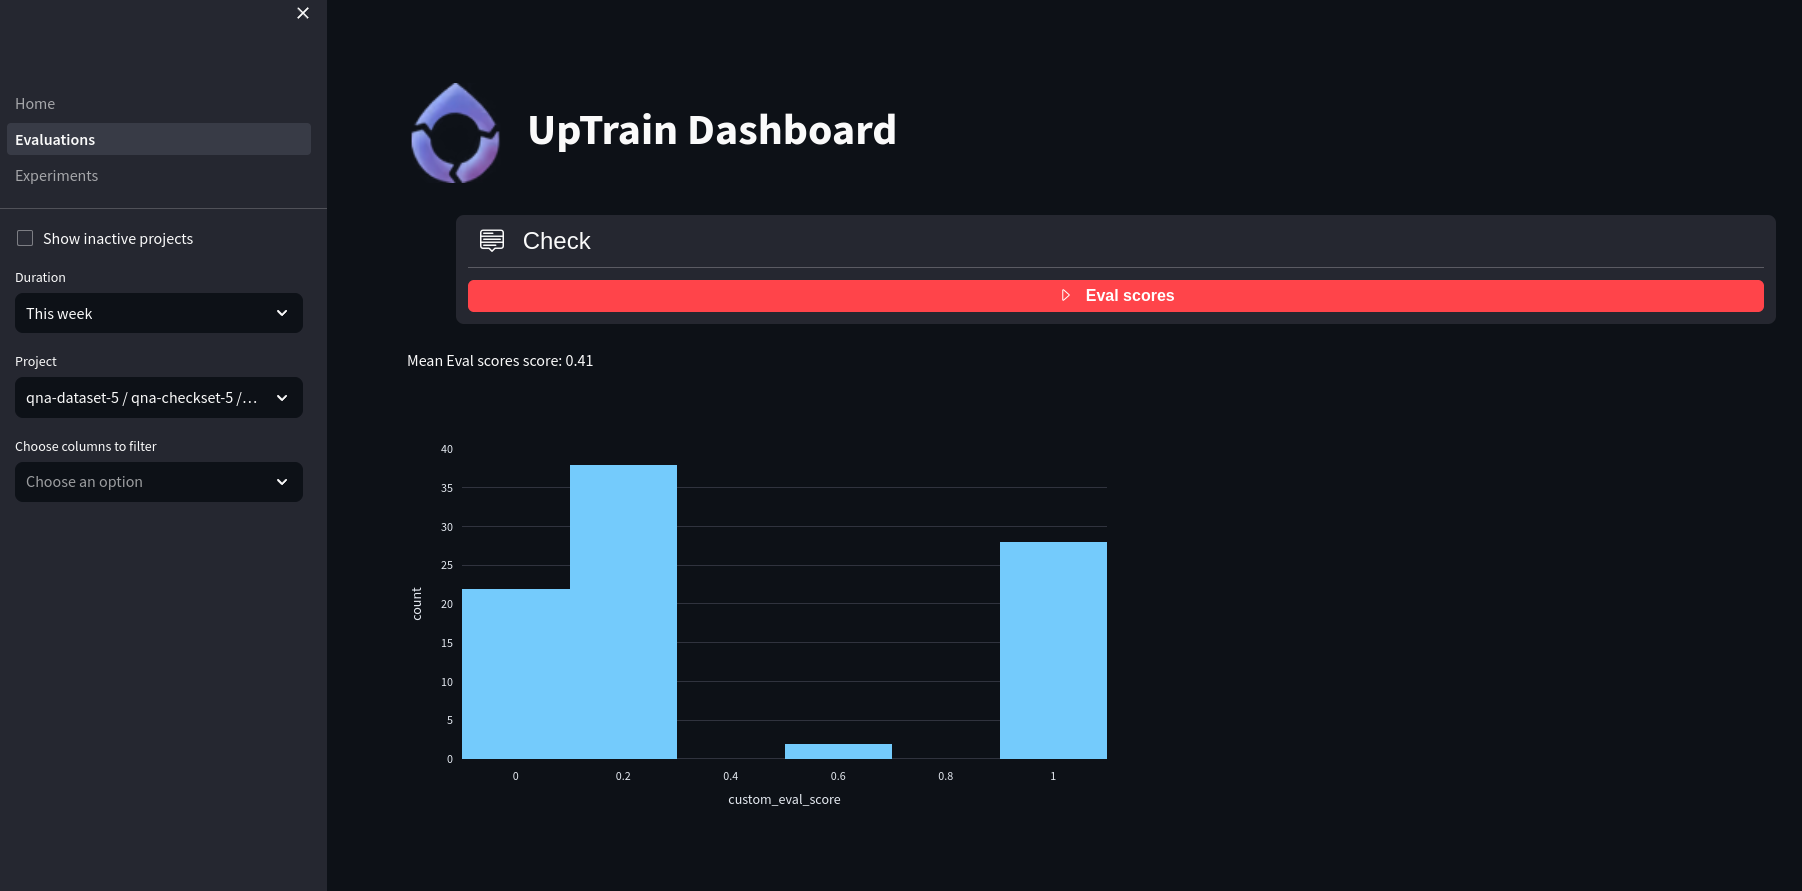